# LM Studio Official Example

In [24]:
from openai import OpenAI
import json

# Initialize OpenAI client that points to the local LM Studio server
client = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio"
)

# Define the conversation with the AI
messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "Create 1-3 fictional characters."},
]

# Define the expected response structure
character_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "characters",
        "schema": {
            "type": "object",
            "properties": {
                "characters": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string"},
                            "occupation": {"type": "string"},
                            "personality": {"type": "string"},
                            "background": {"type": "string"}
                        },
                        "required": ["name", "occupation", "personality", "background"]
                    },
                    "minItems": 1,
                }
            },
            "required": ["characters"]
        },
    }
}

# Get response from AI
response = client.chat.completions.create(
    model="qwen2.5-7b-instruct",
    messages=messages,
    response_format=character_schema,
)

# Parse and display the results
results = json.loads(response.choices[0].message.content)
print(json.dumps(results, indent=2))

{
  "characters": [
    {
      "name": "Aeloria Starfall",
      "occupation": "Enchanted Guardian",
      "personality": "Aeloria is a gentle yet determined spirit, tasked with protecting the mystical realm of Lumina from darkness and preserving its magical balance. Despite her calm demeanor, she harbors an inner strength that allows her to face any challenge. Her past as a celestial guardian shapes her protective nature.",
      "background": "Born in the ethereal skies above Lumina, Aeloria was chosen by the moon deities to maintain the realm's harmony with the keyblade world. She possesses the power of light and is skilled in both magic and combat, though she prefers diplomacy over conflict when possible."
    },
    {
      "name": "Quintus Nightshade",
      "occupation": "Shadow Sorcerer",
      "personality": "Quintus is a mysterious and enigmatic figure who can shift between the realms of light and darkness. He often appears as a scholar or a mage, but his true intentions are

# OpenAI Example

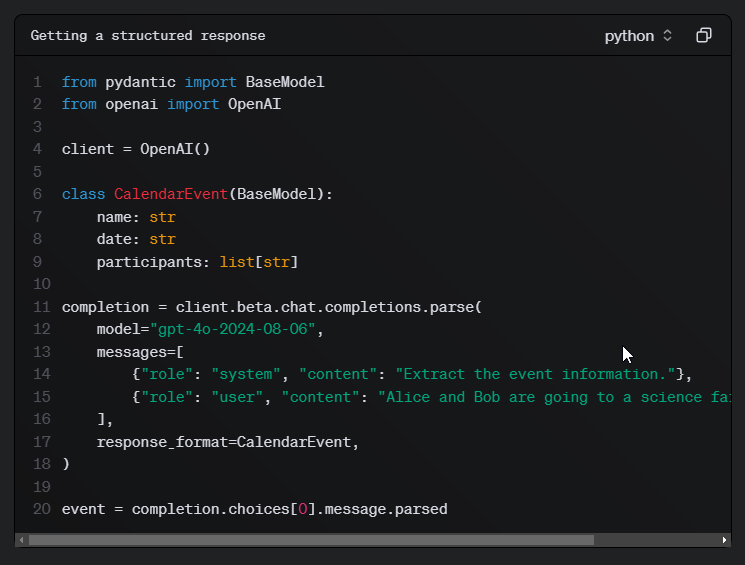

Ref: https://platform.openai.com/docs/guides/structured-outputs?context=ex2

# Working LM Studio Example with Pydantic

In [29]:
from openai import OpenAI
import instructor
from pydantic import BaseModel, Field, ValidationError

# Initialize with API key
client = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio",  # required, but unused
)

# Enable instructor patches for OpenAI client
client = instructor.from_openai(client)

class Book(BaseModel):
    title: str
    author: str
    genre: str
    publication_year: int
    is_bestseller: bool
    is_bestseller_justification: str = Field(description="The reason why it's considered a bestseller.")

def get_book_info(input_text: str) -> Book:
    try:
        response = client.chat.completions.create(
            model="qwen2.5-7b-instruct",
            messages=[
                {"role": "user", "content": input_text},
            ],
            response_model=Book,
        )
        return response
    except ValidationError as e:
        print(f"Validation error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example input text
input_text = """
'The Great Gatsby' is a novel written by F. Scott Fitzgerald. It falls under the genre of classic American literature. 
The book was published in 1925 and is widely regarded as a bestseller due to its timeless themes and engaging plot.
"""

# Get book info from input text
book_info = get_book_info(input_text)
if book_info:
    print(book_info)
else:
    print("Failed to extract book information.")

title='The Great Gatsby' author='F. Scott Fitzgerald' genre='Classic American Literature' publication_year=1925 is_bestseller=True is_bestseller_justification='Due to its timeless themes and engaging plot.'


# Batch Inference (Not Possible without vLLM)

In [1]:
from datasets import load_dataset
from instructor.batch import BatchJob
from pydantic import BaseModel, Field
from datasets import load_dataset

dataset = load_dataset("ms_marco", "v1.1", split="train", streaming=True).take(200)

def get_messages(dataset):  
    for row in dataset:
        for passage in row['passages']['passage_text']:
            yield [
                {
                    "role": "system",
                    "content": "You are a world class AI that excels at generating hypothethical search queries. You're about to be given a text snippet and asked to generate a search query which is specific to the specific text chunk that you'll be given. Make sure to use information from the text chunk.",
                },
                {"role": "user", "content": f"Here is the text chunk: {passage}"},
            ]

class QuestionAnswerPair(BaseModel):
    """
    This model represents a pair of a question generated from a text chunk, its corresponding answer,
    and the chain of thought leading to the answer. The chain of thought provides insight into how the answer
    was derived from the question.
    """

    chain_of_thought: str = Field(
        description="The reasoning process leading to the answer."
    )
    question: str = Field(description="The generated question from the text chunk.")
    answer: str = Field(description="The answer to the generated question.")


BatchJob.create_from_messages(
    messages_batch=get_messages(dataset),
    model="qwen2.5-7b-instruct",
    file_path="./test.jsonl",
    response_model=QuestionAnswerPair,
)